In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
%config InlineBackend.figure_format = 'retina' #better quality plots

import astropy.coordinates as coord
from astropy import constants as const
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Gala
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
with coord.galactocentric_frame_defaults.set('v4.0'): galcen_frame = coord.Galactocentric()

A new version of galpy (1.10.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
class Hernquist():
    """
    Hernquist model.
    """
    def __init__(self,G=1,M=1,c=1):
        self.c       = c
        self.G       = G
        self.M       = M
    def get_pot(self,r):
        c = self.c
        return -self.G*self.M/(r + c)
    def get_dphi_dr(self,r):
        c = self.c
        return self.G*self.M/(r + c)**2

In [3]:
class NFW():
    """
    NFW model.
    """
    def __init__(self,G=1,M=1,rs=1):
        self.rs   = rs
        self.G    = G
        self.M    = M
        self.rho0 = self.get_rho0()
    def get_rho0(self):
        rs = self.rs
        return self.M/(4*np.pi*np.power(rs,3)) 
    def get_pot(self,r):
        rs = self.rs
        return -(self.G*self.M)/r * np.log(1 + (r/rs)) 
    def get_dphi_dr(self,r):
        rs = self.rs
        return (self.G*self.M)/r * (np.log(1 + (r/rs))/r - (1/(rs + r))) 

In [4]:
class MN():
    """
    Miyamoto-Nagai model.
    """
    def __init__(self,a=1.0,b=1.0,G=1,M=1):
        self.a    = a
        self.b    = b
        self.G    = G
        self.M    = M
    def get_pot(self,R,z):
        return (-self.G*self.M)/(np.sqrt(R**2 + (np.sqrt(z**2 + self.b**2) + self.a)**2))
    def get_dphi_dR(self, R, z):
        return (self.G*self.M*R)/(R**2 + (self.a + np.sqrt(self.b**2 + z**2))**2)**(3/2)
    def get_dphi_dz(self, R, z):
        return (self.G*self.M*z*(self.a + np.sqrt(self.b**2 + z**2)))/(((R**2 + (self.a + np.sqrt(self.b**2 + z**2))**2)**(3/2))*np.sqrt(self.b**2 + z**2))

In [5]:
# Initial conditions from gala:
# http://gala.adrian.pw/en/v1.2/potential/define-milky-way-model.html
# https://github.com/adrn/gala/blob/2fee111043604164bade00c9ac921629b8badf8b/gala/potential/potential/builtin/cybuiltin.pyx

# G_const = 4.3e-6 # kpc km2 s-2 M⊙-1
# MN_disk = MN(a=3.0, b=0.28, M=6.8e10, G=G_const) # converted b to kpc
# Hern_bulge_sph = Hernquist(M=5e9, c=1, G=G_const) # assumed c in kpc
# Hern_nucl_sph = Hernquist(M=1.71e9, c=0.07, G=G_const)
# NFW_halo_sph = NFW(M=5.4e11, rs=15.62, G=G_const)

In [6]:
# Defined r -> spherical and R -> cylindrical

def sph_to_cart(dr,variables):
    """
    Converts from spherical accelerations to cartesian.
    """
    x = variables[0]
    y = variables[1]
    z = variables[2]
    r = variables[3]
    
    ax = -dr * (x/r)
    ay = -dr * (y/r)
    az = -dr * (z/r)
    return ax, ay, az

###################

def cyl_to_cart(dR,dz,variables):
    """
    Converts from cylindrical accelerations to cartesian.
    """
    x = variables[0]
    y = variables[1]
    R = variables[4]
    
    ax = -dR * (x/R)
    ay = -dR * (y/R)
    az = -dz
    return ax, ay, az

###################

def convert_coords(shape, **kwargs):
    """If spherical portential (sph), converts from spherical coordinates, 
    if cylindircal potential (disk), converts from cylindrical coordinates.
    """
    if shape=='sph':
        dr = kwargs.get('dphi_dr')
        variables = kwargs.get('variables')
        # Now I need to convert from spherical to cartesian 
        ax, ay, az = sph_to_cart(dr,variables)
        return ax, ay, az
    
    if shape=='disk':
        dR = kwargs.get('dphi_dR')
        dz = kwargs.get('dphi_dz')
        variables = kwargs.get('variables')
        # Now I need to convert from cylindrical to cartesian 
        ax, ay, az = cyl_to_cart(dR,dz,variables)
        return ax, ay, az

###################

def find_accel(potential, variables):    
    """
    Parameters
    ----------
    potential : str
        NFW_halo_sph, Hern_bulge_sph, Hern_nucl_sph, MN_disk, all
    x : array
        x-postions
    y : array
        y-postions
    z : array
        z-postions
    r : array (spherical coordinates)
        r-postions
    R : array
        R-postions (cylindrical coordinates)
    
        
    Returns
    ----------
    (due to chosen potential)
    ax : array
        x-accelerations 
    ay : array
        y-accelerations 
    az : array
        z-accelerations
    """
    
    x = variables[0]
    y = variables[1]
    z = variables[2]
    r = variables[3]
    R = variables[4]
    
    if potential=='NFW_halo_sph':
        ax, ay, az = convert_coords(potential.split('_')[2], dphi_dr=NFW_halo_sph.get_dphi_dr(r),
                                   variables=variables)
        pot = NFW_halo_sph.get_pot(r)
        return ax, ay, az
    
    if potential=='Hern_bulge_sph':
        ax, ay, az = convert_coords(potential.split('_')[2], dphi_dr=Hern_bulge_sph.get_dphi_dr(r),
                                   variables=variables)
        pot = Hern_bulge_sph.get_pot(r)
        return ax, ay, az
    
    if potential=='Hern_nucl_sph':
        ax, ay, az = convert_coords(potential.split('_')[2], dphi_dr=Hern_nucl_sph.get_dphi_dr(r),
                                   variables=variables)
        pot = Hern_nucl_sph.get_pot(r)
        return ax, ay, az
    
    if potential=='MN_disk':        
        ax, ay, az = convert_coords(potential.split('_')[1], dphi_dR=MN_disk.get_dphi_dR(R,z), 
                                    dphi_dz=MN_disk.get_dphi_dz(R, z), variables=variables)
        pot = MN_disk.get_pot(R,z)
        return ax, ay, az
    
    if potential=='all': 
        ax1, ay1, az1 = find_accel('MN_disk', variables)
        ax2, ay2, az2 = find_accel('Hern_bulge_sph', variables)
        ax3, ay3, az3 = find_accel('Hern_nucl_sph', variables)
        ax4, ay4, az4 = find_accel('NFW_halo_sph', variables)
        
        ax = sum([ax1, ax2, ax3, ax4])
        ay = sum([ay1, ay2, ay3, ay4])
        az = sum([az1, az2, az3, az4])
        return ax, ay, az
    
    raise NameError(f"Given: {potential}, Expected string, one of: NFW_halo_sph, Hern_bulge_sph, Hern_nucl_sph, MN_disk, all")

In [7]:
# Referenced http://cvarin.github.io/CSci-Survival-Guide/leapfrog.html
# Units of potentials as I have defined them give units ~Gyr
# It is assumed the intial acceleration(s) are zero (can be modified)

def leapfrog(potential, x_0, y_0, z_0, vx_0, vy_0, vz_0, dt, N):
    """
    Parameters
    ----------
    potential : str
        NFW_halo_sph, Hern_bulge_sph, Hern_nucl_sph, MN_disk, all
    x_0  : int or float
        intial x-postion
    y_0  : int or float
        intial y-postion
    z_0  : int or float
        intial z-postion
    vx_0 : int or float
        intial x-velocity
    vy_0 : int or float
        intial y-veloctiy
    vz_0 : int or float
        intial z-velocity
    dt   : int or float
        timestep to increment over
    N    : int or float
        total number of (time)steps
    
        
    Returns
    ----------
    (due to chosen potential and time)
    x : array
        x-postions
    y : array
        y-postions
    z : array
        z-postions
    vx : array
        x-velocities
    vy : array
        y-velocities
    vz : array
        z-velocities
    ax : array
        x-accelerations 
    ay : array
        y-accelerations
    az : array
        z-accelerations
    """
    
    dt_ = dt
    t = np.arange(0,N*dt_,dt_)
    
    x = np.zeros(len(t))
    y = np.zeros(len(t))
    z = np.zeros(len(t))
    
    vx = np.zeros(len(t))
    vy = np.zeros(len(t))
    vz = np.zeros(len(t))
    
    ax = np.zeros(len(t))
    ay = np.zeros(len(t))
    az = np.zeros(len(t))
    
    x[0] = x_0
    y[0] = y_0
    z[0] = z_0
    
    vx[0] = vx_0
    vy[0] = vy_0
    vz[0] = vz_0
    
    for i in range(len(t)-1):
    # Pass these along to next function
        variables = x[i], y[i], z[i], np.sqrt(x[i]**2 + y[i]**2 + z[i]**2), np.sqrt(x[i]**2 + y[i]**2)
        ax[i], ay[i], az[i] = find_accel(potential, variables) # Calculate acceleration at current position 
    
        vx_plushalf = vx[i] + ax[i]*dt*(1/2)
        x[i+1] = x[i] + vx_plushalf*dt # Find new position given previous particle velocity and acceleration
        
        vy_plushalf = vy[i] + ay[i]*dt*(1/2)
        y[i+1] = y[i] + vy_plushalf*dt
        
        vz_plushalf = vz[i] + az[i]*dt*(1/2)
        z[i+1] = z[i] + vz_plushalf*dt
        
        variables = x[i+1], y[i+1], z[i+1], np.sqrt(x[i+1]**2 + y[i+1]**2 + z[i+1]**2), np.sqrt(x[i+1]**2 + y[i+1]**2)
        ax[i+1], ay[i+1], az[i+1] = find_accel(potential, variables) # Find new acceleration
        
        vx[i+1] = vx_plushalf + ax[i+1]*dt*(1/2) # Find new velocity given new acceleration
        vy[i+1] = vy_plushalf + ay[i+1]*dt*(1/2)
        vz[i+1] = vz_plushalf + az[i+1]*dt*(1/2)
    return x, y, z, vx, vy, vz, ax, ay, az, t

In [8]:
# x, y, z, vx, vy, vz, ax, ay, az = leapfrog('MN_disk', 10, 0, 0, 0, 40, 0, 0.005, 1000) # Working example

# Experimenting... Herc coords below.
# x, y, z, vx, vy, vz, ax, ay, az = leapfrog('all', 84699.06301838*0.001, 50765.17036287*0.001, 78958.45060182*0.001,
#                                           172.86159755, 86.22236088, 0.60765245, 0.05, 500)

# Hercules coords:
#             x = 84699.06301838*0.001, y = 50765.17036287*0.001, z = 78958.45060182*0.001, 
#             vx = 172.86159755,       vy = 86.22236088,         vz = 0.60765245 

In [9]:
MN_disk_dict = {'m': 6.8e10*u.Msun, 'a': 3.0*u.kpc, 'b': 0.28*u.kpc} # MN_disk = MN(a=3.0, b=0.28, M=6.8e10, G=G_const
Hern_bulge_dict = {'m': 5e9*u.Msun, 'c': 1*u.kpc} # Hern_bulge_sph = Hernquist(M=5e9, c=1, G=G_const) # assumed c in kpc
Hern_nucl_dict = {'m': 1.71e9*u.Msun, 'c': 0.07*u.kpc} # Hern_nucl_sph = Hernquist(M=1.71e9, c=0.07, G=G_const)
NFW_halo_dict = {'m': 5.4e11*u.Msun, 'r_s': 15.62*u.kpc} # NFW_halo_sph = NFW(M=5.4e11, rs=15.62, G=G_const)

# mw_potential = gp.MilkyWayPotential(units=galactic,disk=MN_disk_dict, halo=NFW_halo_dict, 
#                                     bulge=Hern_bulge_dict, nucleus=Hern_nucl_dict)


# w0 = gd.PhaseSpacePosition(pos=[84699.06301838*0.001, 50765.17036287*0.001, 78958.45060182*0.001]*u.kpc, 
#                                 vel=[172.86159755, 86.22236088, 0.60765245]*u.km/u.s)

# w0 = gd.PhaseSpacePosition(pos=[10, 0, 0]*u.kpc, vel=[0, 40, 0]*u.km/u.s)

In [10]:
from gala.units import UnitSystem

usys = UnitSystem(u.kpc, u.Gyr, u.radian, u.Msun, u.km/u.s)
usys.get_constant('G')
# usys['mass']

4.498502151469553e-06

In [10]:
#star_orbit = mw_potential.integrate_orbit(w0, dt=0.5*u.Myr, t1=0, t2=100*u.Gyr)
# star_orbit = mw_potential.integrate_orbit(w0, dt=0.005*u.Myr, t1=0, t2=5*u.Gyr)

In [11]:
G_const = 4.5e-6 # kpc**3 / (M_sun * Gyrs**2) [in Gyrs]
MN_disk = MN(a=3.0, b=0.28, M=6.8e10, G=G_const) # converted b to kpc
Hern_bulge_sph = Hernquist(M=5e9, c=1, G=G_const) # assumed c in kpc
Hern_nucl_sph = Hernquist(M=1.71e9, c=0.07, G=G_const)
NFW_halo_sph = NFW(M=5.4e11, rs=15.62, G=G_const)

Text(0, 0.5, 'V$_{circ}$')

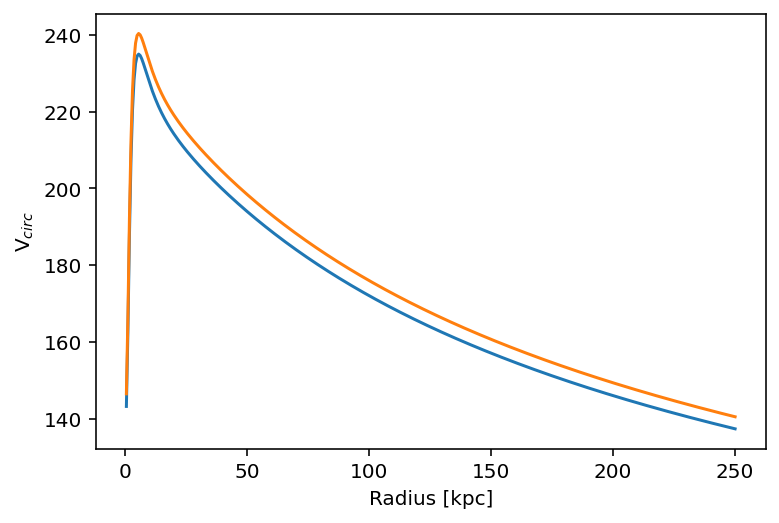

In [16]:
x = np.linspace(0.,250.,400)
y = np.zeros(x.shape[0])
z = np.zeros(x.shape[0])

r = np.sqrt(x**2 + y**2 + z**2)
R = np.sqrt(x**2 + y**2)

# r_alt = np.linspace(0,300,50) * u.kpc
# r_temp = np.zeros(r_alt.shape[0]) * u.kpc
# test = np.sqrt(-r_alt[1:]*mw_potential.acceleration([r_alt,r_temp,r_temp]).T[1:,0])
# plt.plot(r_alt[1:], test)


mw_potential = gp.MilkyWayPotential(units=usys,disk=MN_disk_dict, halo=NFW_halo_dict, 
                                    bulge=Hern_bulge_dict, nucleus=Hern_nucl_dict)

gala_vcirc = mw_potential.circular_velocity([x * u.kpc,y * u.kpc,z * u.kpc])
plt.plot(r * u.kpc, gala_vcirc)

vcirc = np.sqrt( (r * (Hern_nucl_sph.get_dphi_dr(r)+Hern_bulge_sph.get_dphi_dr(r)+NFW_halo_sph.get_dphi_dr(r)) ) + ( R * MN_disk.get_dphi_dR(R, z) ) ) 
plt.plot(r, vcirc)
plt.xlabel('Radius [kpc]')
plt.ylabel('V$_{circ}$')



R_v = 250.0, Vc_v = 140.48873703209873
M_v = 1096504735159.6771


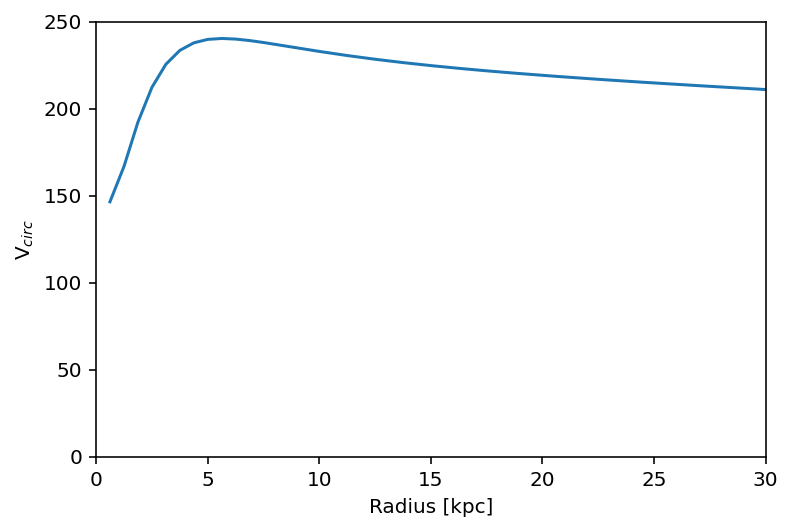

In [18]:
plt.plot(r, vcirc)
plt.ylim(0,250)
plt.xlim(0,30)
plt.xlabel('Radius [kpc]')
plt.ylabel('V$_{circ}$')

print('R_v = ' + str(r[-1]) + ', Vc_v = ' + str(vcirc[-1]))
print('M_v = ' + str((vcirc[-1]**2 * r[-1])/G_const))

M_v = (vcirc[-1]**2 * r[-1])/G_const
R_v = r[-1]
Vc_v = vcirc[-1]

Text(0, 0.5, 'Mass Enclosed')

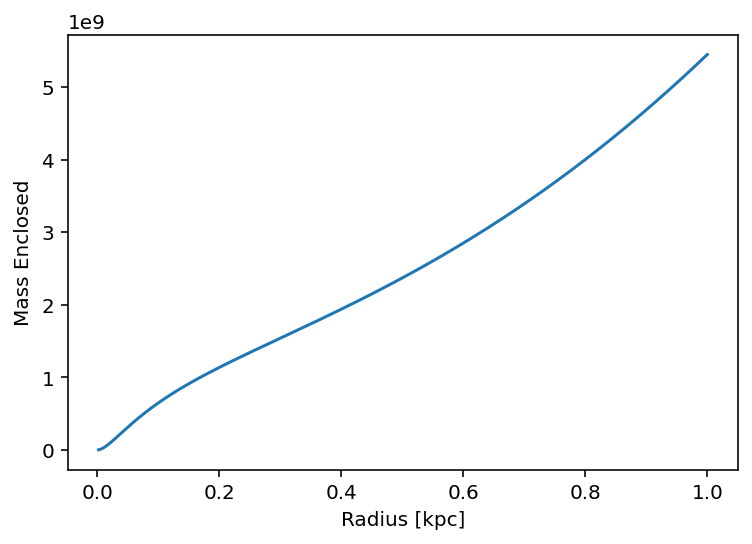

In [23]:
fit_menc = mw_potential.mass_enclosed([x * u.kpc,y * u.kpc,z * u.kpc])
plt.plot(r * u.kpc, fit_menc)
plt.xlabel('Radius [kpc]')
plt.ylabel('Mass Enclosed')

In [20]:
mod_MN_disk = MN(a=3.0/R_v, b=0.28/R_v, M=6.8e10/M_v) # converted b to kpc
mod_Hern_bulge_sph = Hernquist(M=5e9/M_v, c=1/R_v) # assumed c in kpc
mod_Hern_nucl_sph = Hernquist(M=1.71e9/M_v, c=0.07/R_v)
mod_NFW_halo_sph = NFW(M=5.4e11/M_v, rs=15.62/R_v)

Text(0, 0.5, 'V$_{circ}$')

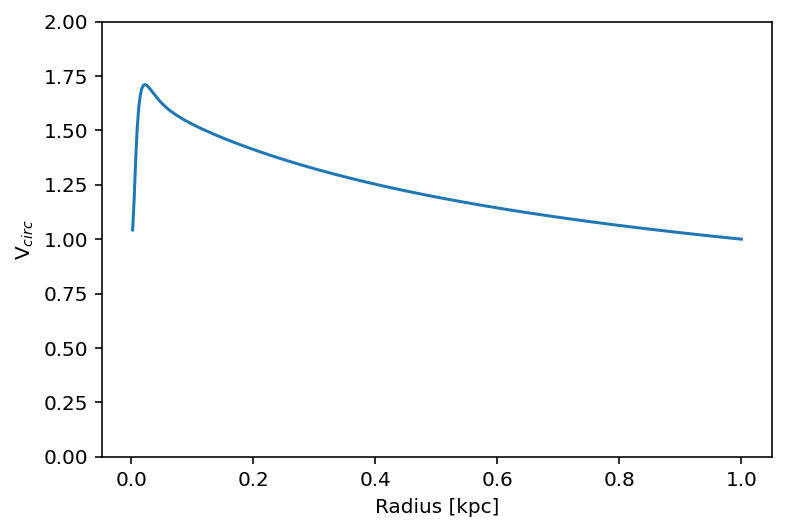

In [24]:
x = np.linspace(0.,250.,400)/R_v
y = np.zeros(x.shape[0])
z = np.zeros(x.shape[0])

# mw_potential = gp.MilkyWayPotential(units=galactic,disk=MN_disk_dict, halo=NFW_halo_dict, 
#                                     bulge=Hern_bulge_dict, nucleus=Hern_nucl_dict)

r = np.sqrt(x**2 + y**2 + z**2)
R = np.sqrt(x**2 + y**2)

vcirc = np.sqrt( (r * (mod_Hern_nucl_sph.get_dphi_dr(r)+mod_Hern_bulge_sph.get_dphi_dr(r)+mod_NFW_halo_sph.get_dphi_dr(r)) ) + ( R * mod_MN_disk.get_dphi_dR(R, z) ) ) 

#gala_vcirc = mw_potential.circular_velocity([x,y,z])

plt.plot(r, vcirc)
plt.ylim(0,2)
plt.xlabel('Radius [kpc]')
plt.ylabel('V$_{circ}$')

In [25]:
def v_units(G, M, R):
    v = np.sqrt(G*M/R)
    return v

v_scaling = v_units(G_const, M_v, R_v)/v_units(G=1, M=3.7 * 10**4, R=0.3)
print(v_scaling)

0.4000380242015601


Text(0.5, 1.0, 'All')

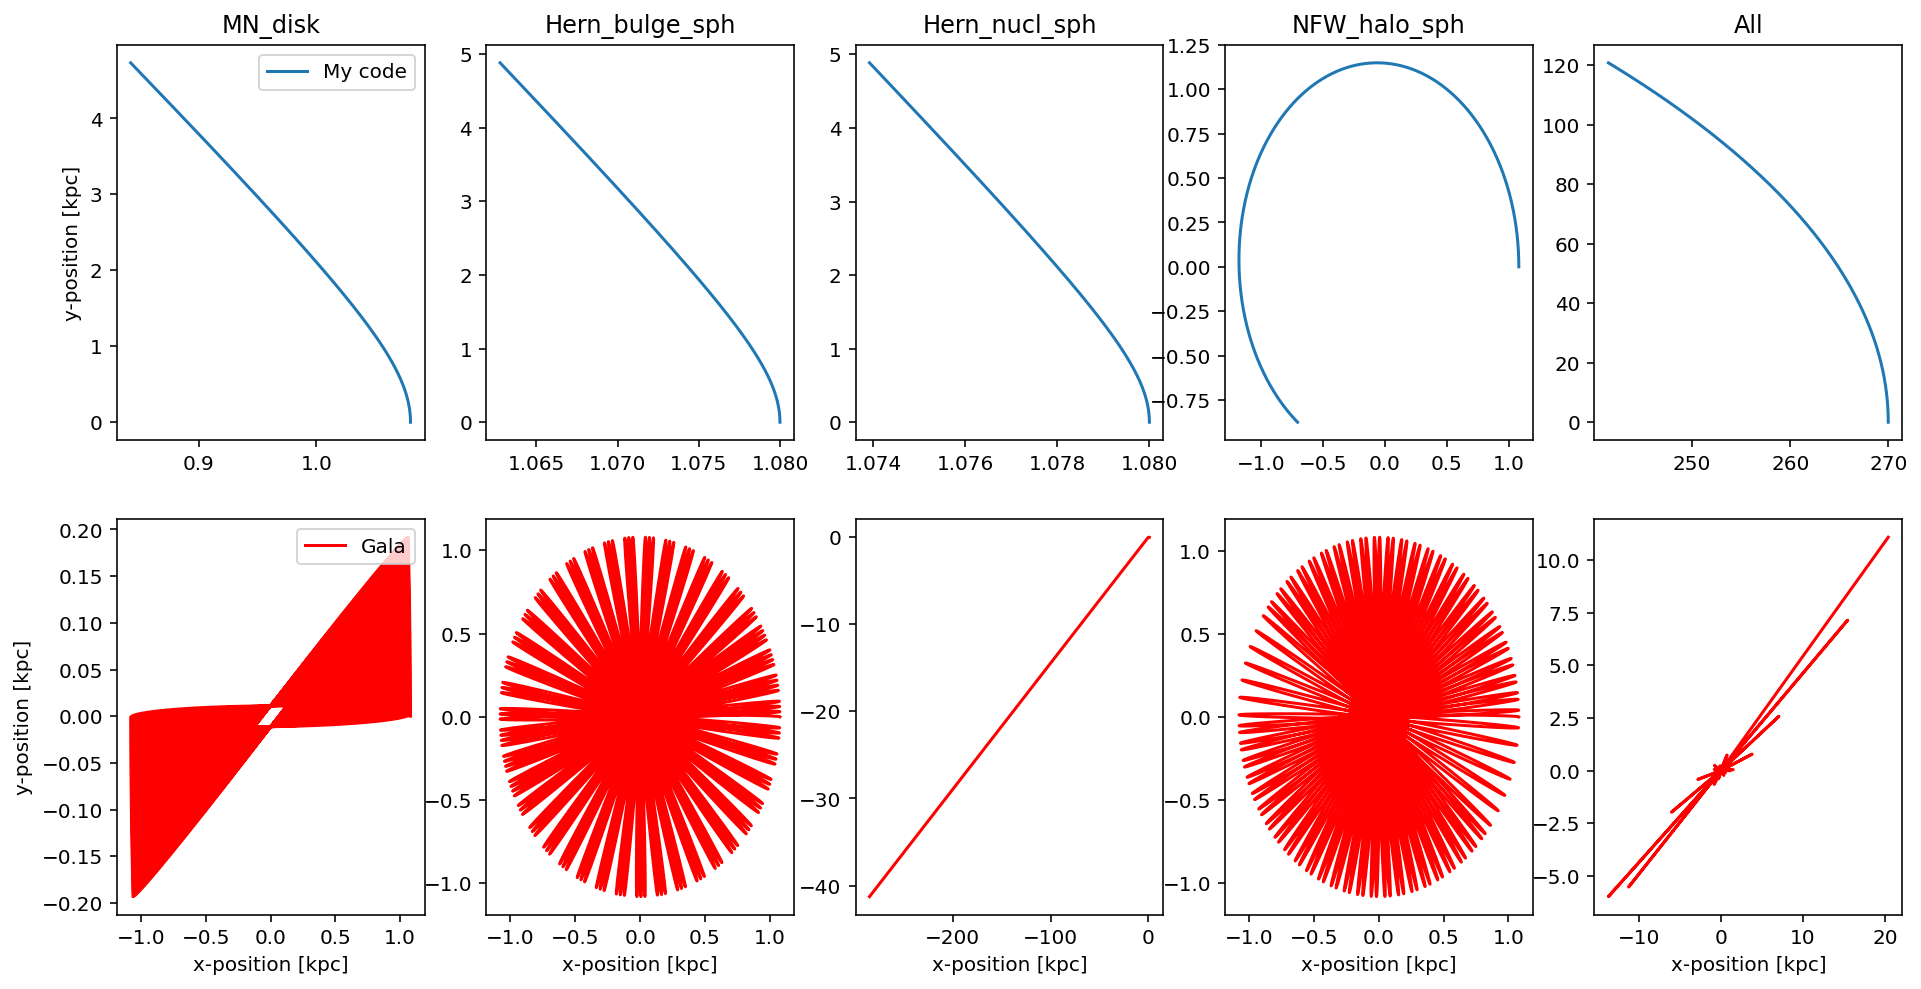

In [26]:
fig, axs = plt.subplots(2, 5, figsize=(16, 8))

xi = 1.08
vyi = 0.978

# G_const = 4.3e-6 # kpc**3 / (M_sun * Gyrs**2) [in Gyrs]
# MN_disk = MN(a=3.0, b=0.28, M=6.8e10, G=G_const) # converted b to kpc
# Hern_bulge_sph = Hernquist(M=5e9, c=1, G=G_const) # assumed c in kpc
# Hern_nucl_sph = Hernquist(M=1.71e9, c=0.07, G=G_const)
# NFW_halo_sph = NFW(M=5.4e11, rs=15.62, G=G_const)

G_const = 1
MN_disk = MN(a=0.0120, b=0.0011, M=0.0620) # converted b to kpc
Hern_bulge_sph = Hernquist(M=0.00456, c=0.0040) # assumed c in kpc
Hern_nucl_sph = Hernquist(M=0.0016, c=0.0003)
NFW_halo_sph = NFW(M=0.4925, rs=0.0625)

# --------------

x1, y1, z1, vx1, vy1, vz1, ax1, ay1, az1, t1 = leapfrog('MN_disk', xi, 0, 0, 0, vyi, 0, 0.0005, 10000) 
mw_potential = gp.MiyamotoNagaiPotential(m=6.8e10*u.Msun, a=3.0*u.kpc, b=0.28*u.kpc, units=galactic)
w0 = gd.PhaseSpacePosition(pos=[xi, 0, 0]*u.kpc, vel=[0, vyi, 0]*u.km/u.s)
star_orbit = mw_potential.integrate_orbit(w0, dt=0.05*u.Myr, t1=0, t2=5*u.Gyr)

axs[0,0].plot(x1,y1, label='My code') # Doesn't match gala ranges...
axs[1,0].plot(star_orbit.x, star_orbit.y, label='Gala', c ='red')

# --------------

x2, y2, z2, vx2, vy2, vz2, ax2, ay2, az2, t2 = leapfrog('Hern_bulge_sph', xi, 0, 0, 0, vyi, 0, 0.0005, 10000) 
mw_potential = gp.HernquistPotential(m=5e9*u.Msun, c=1*u.kpc, units=galactic)
w0 = gd.PhaseSpacePosition(pos=[xi, 0, 0]*u.kpc, vel=[0, vyi, 0]*u.km/u.s)
star_orbit = mw_potential.integrate_orbit(w0, dt=0.05*u.Myr, t1=0, t2=5*u.Gyr)

axs[0,1].plot(x2,y2, label='My code') # Doesn't match gala ranges...
axs[1,1].plot(star_orbit.x, star_orbit.y, label='Gala', c ='red')

# --------------

x3, y3, z3, vx3, vy3, vz3, ax3, ay3, az3, t3 = leapfrog('Hern_nucl_sph', xi, 0, 0, 0, vyi, 0, 0.0005, 10000) 
mw_potential = gp.HernquistPotential(m=1.71e9*u.Msun, c=0.07*u.kpc, units=galactic)
w0 = gd.PhaseSpacePosition(pos=[xi, 0, 0]*u.kpc, vel=[0, vyi, 0]*u.km/u.s)
star_orbit = mw_potential.integrate_orbit(w0, dt=0.05*u.Myr, t1=0, t2=5*u.Gyr)

axs[0,2].plot(x3,y3, label='My code') # Doesn't match gala ranges...
axs[1,2].plot(star_orbit.x, star_orbit.y, label='Gala', c ='red')

# --------------

x4, y4, z4, vx4, vy4, vz4, ax4, ay4, az4, t4 = leapfrog('NFW_halo_sph', xi, 0, 0, 0, vyi, 0, 0.0005, 10000) 
mw_potential = gp.NFWPotential(m=5.4e11*u.Msun, r_s=15.62*u.kpc, units=galactic)
w0 = gd.PhaseSpacePosition(pos=[xi, 0, 0]*u.kpc, vel=[0, vyi, 0]*u.km/u.s)
star_orbit = mw_potential.integrate_orbit(w0, dt=0.05*u.Myr, t1=0, t2=5*u.Gyr)

axs[0,3].plot(x4,y4, label='My code') # Doesn't match gala ranges...
axs[1,3].plot(star_orbit.x, star_orbit.y, label='Gala', c ='red')

# --------------

x, y, z, vx, vy, vz, ax, ay, az, t = leapfrog('all', xi, 0, 0, 0, vyi, 0, 1.6e-5, 32000) 

mw_potential = gp.MilkyWayPotential(units=galactic,disk=MN_disk_dict, halo=NFW_halo_dict, 
                                    bulge=Hern_bulge_dict, nucleus=Hern_nucl_dict)
w0 = gd.PhaseSpacePosition(pos=[xi, 0, 0]*u.kpc, vel=[0, vyi, 0]*u.km/u.s)
star_orbit = mw_potential.integrate_orbit(w0, dt=0.05*u.Myr, t1=0, t2=.98*u.Gyr)

axs[0,4].plot(x*250,y*250, label='My code') # Doesn't match gala ranges...
axs[1,4].plot(star_orbit.x, star_orbit.y, label='Gala', c ='red')

# --------------

axs[0,0].legend(loc='upper right')
axs[1,0].legend(loc='upper right')

axs[0,0].set_ylabel('y-position [kpc]')
axs[1,0].set_ylabel('y-position [kpc]')

axs[1,0].set_xlabel('x-position [kpc]')
axs[1,1].set_xlabel('x-position [kpc]')
axs[1,2].set_xlabel('x-position [kpc]')
axs[1,3].set_xlabel('x-position [kpc]')
axs[1,4].set_xlabel('x-position [kpc]')

axs[0,0].set_title('MN_disk')
axs[0,1].set_title('Hern_bulge_sph')
axs[0,2].set_title('Hern_nucl_sph')
axs[0,3].set_title('NFW_halo_sph')
axs[0,4].set_title('All')

In [27]:
# ax_out = sum([ax1, ax2, ax3, ax4])
# ay_out = sum([ay1, ay2, ay3, ay4])
# az_out = sum([az1, az2, az3, az4])

# ax_out == ax

In [13]:
# r = np.sqrt(x**2 + y**2)
# dr = -ax / (x/r)
# vc = np.sqrt(dr * r) # http://www.sr.bham.ac.uk/~tjp/FEG/hand2.pdf Eqn. 2.3

In [14]:
# Lz = x*vy - y*vx
# Ly = z*vx - x*vz
# Lx = y*vz - z*vy

# t = np.arange(0,3000*0.005,0.005)
# plt.plot(t, Lz)
# plt.plot(t, Ly)
# plt.plot(t, Lx)

# Testing each component

## Hernquist

In [29]:
# x = np.linspace(0.,10.,50)
# y = np.linspace(0.,10.,50)
# z = np.zeros(len(x))

# radii = [np.sqrt(x**2 + y**2), x, y]
# # plt.xlabel('r')
# # plt.ylabel('$v_{circ}$')

# vcirc = np.sqrt(radii[0]*Hern_nucl_sph.get_dphi_dr(radii[0])) 
# # plt.plot(radii[0], vcirc, label='Hern_nucl_sph')

# # vcirc = np.sqrt(radii[0]*Hern_bulge_sph.get_dphi_dr(radii[0]))
# # plt.plot(radii[0], vcirc, label='Hern_bulge_sph')
# # plt.legend()

# r = radii[0]

In [16]:
# x, y, z, vx, vy, vz, ax, ay, az = leapfrog('Hern_nucl_sph', r[4], 0, 0, 0, vcirc[4], 0, 0.005, 200)

In [17]:
# r_test = np.sqrt(x**2 + y**2 + z**2)
# PE = Hern_bulge_sph.get_pot(r_test)
# KE = 1/2*(vx**2 + vy**2 + vz**2)
# TE = PE + KE
# # print(r_test)
# # print(Hern_nucl_sph.G)

# t = np.arange(0,2000*0.0005,0.0005)
# plt.plot(t, TE, label='TE')
# plt.plot(t, PE, label='PE')
# plt.plot(t, KE, label='KE')

# plt.legend()

In [18]:
# plt.plot(t, (TE-TE[0])/TE[0])
# print((max(TE)-min(TE))/len(TE)) # Original

In [19]:
# plt.plot(x,y)

In [20]:
# Lz = x*vy - y*vx
# Ly = z*vx - x*vz
# Lx = y*vz - z*vy

# t = np.arange(0,2000*0.005,0.005)
# plt.plot(t, Lz)
# plt.plot(t, Ly)
# plt.plot(t, Lx)

In [31]:
# Hern_bulge_sph = Hernquist(M=5e9, c=1, G=G_const) # assumed c in kpc
# Hern_nucl_sph = Hernquist(M=1.71e9, c=0.07, G=G_const)

# mw_potential = gp.HernquistPotential(m=1.71e9*u.Msun, c=0.07*u.kpc, units=galactic)
# gala_vcirc = mw_potential.circular_velocity([x,y,z])

# w0 = gd.PhaseSpacePosition(pos=[r[4], 0, 0]*u.kpc, vel=[0, 75.252, 0]*u.km/u.s)
# star_orbit = mw_potential.integrate_orbit(w0, dt=0.5*u.Myr, t1=0, t2=20*u.Gyr)

In [33]:
# plt.plot(radii[0], vcirc, label='My code')
# plt.plot(radii[0]+0.1, gala_vcirc, label='Gala')
# plt.legend()

In [23]:
# plt.plot(x_pos,y_pos, label='My code') # Offset to see difference
# plt.plot(star_orbit.x, star_orbit.y, label='Gala')
# plt.legend()

## NFW

In [34]:
# x = np.linspace(0.,80.,100)
# y = np.linspace(0.,80.,100)
# z = np.zeros(len(x))

# radii = [np.sqrt(x**2 + y**2), x, y]

# # plt.title('NFW_halo_sph')
# # plt.xlabel('r')
# # plt.ylabel('$v_{circ}$')
# vcirc = np.sqrt(radii[0]*NFW_halo_sph.get_dphi_dr(radii[0]))
# #plt.plot(radii[0], vcirc)

# r = radii[0]

In [25]:
#x, y, z, vx, vy, vz, ax, ay, az = leapfrog('NFW_halo_sph', r[4], 0, 0, 0, vcirc[4], 0, 0.005, 200)

In [26]:
# r_test = np.sqrt(x**2 + y**2 + z**2)
# PE = NFW_halo_sph.get_pot(r_test)
# KE = 1/2*(vx**2 + vy**2 + vz**2)
# TE = PE + KE

# t = np.arange(0,200*0.005,0.005)

# plt.plot(t, TE, label='TE')
# plt.plot(t, PE, label='PE')
# plt.plot(t, KE, label='KE')

# plt.legend()

In [27]:
# plt.plot(t, (TE-TE[0])/TE[0])
# print((max(TE)-min(TE))/len(TE))

In [28]:
# Lz = x*vy - y*vx
# Ly = z*vx - x*vz
# Lx = y*vz - z*vy

# t = np.arange(0,200*0.005,0.005)
# plt.plot(t, Lz)
# plt.plot(t, Ly)
# plt.plot(t, Lx)

In [35]:
# NFW_halo_sph = NFW(M=5.4e11, rs=15.62, G=G_const)
# mw_potential = gp.NFWPotential(m=5.4e11*u.Msun, r_s=15.62*u.kpc, units=galactic)
# gala_vcirc = mw_potential.circular_velocity([x,y,z])
# print(gala_vcirc[0])
# w0 = gd.PhaseSpacePosition(pos=[r[4], 0, 0]*u.kpc, vel=[0, vcirc[4], 0]*u.km/u.s)
# star_orbit = mw_potential.integrate_orbit(w0, dt=0.5*u.Myr, t1=0, t2=20*u.Gyr)

In [36]:
# plt.plot(radii[0], vcirc, label='My code')
# plt.plot(radii[0]+0.5, gala_vcirc, label='Gala')
# plt.legend()

In [31]:
# plt.plot(x+0.05,y+0.05, label='My code') # Offset to see difference
# plt.plot(star_orbit.x, star_orbit.y, label='Gala')
# plt.legend()

## MN

In [41]:
# x = np.linspace(0.,80.,100)
# y = np.linspace(0.,80.,100)
# z = np.zeros(len(x))

# radii = [np.sqrt(x**2 + y**2), x, y]

# vcirc = np.sqrt(radii[0]*MN_disk.get_dphi_dR(radii[0], z))
# # plt.title('MN_disk')
# # plt.xlabel('R')
# # plt.ylabel('$v_{circ}$')
# # plt.plot(radii[0], vcirc)

# r = radii[0]

In [33]:
# x, y, z, vx, vy, vz, ax, ay, az = leapfrog('MN_disk', r[4], 0, 0, 0, vcirc[4], 0, 0.0005, 2000)

In [42]:
# R_test = np.sqrt(x**2 + y**2)
# PE = MN_disk.get_pot(R_test, z)
# KE = 1/2*(vx**2 + vy**2)
# TE = PE + KE

# t = np.arange(0,200*0.005,0.005)

# plt.plot(t, TE, label='TE')
# plt.plot(t, PE, label='PE')
# plt.plot(t, KE, label='KE')

# plt.legend()

In [35]:
# t = np.arange(0,200*0.005,0.005)
# plt.plot(t, (TE-TE[0])/TE[0])

In [36]:
# # For comparison (higher resolution)
# x, y, z, vx, vy, vz, ax, ay, az = leapfrog('MN_disk', 4.6, 0, 0, 0, 185, 0, 0.0005, 2000)

# R_test = np.sqrt(x**2 + y**2)
# PE = MN_disk.get_pot(R_test, z)
# KE = 1/2*(vx**2 + vy**2)
# TE = PE + KE
# t = np.arange(0,2000*0.0005,0.0005)


# plt.plot(t, (TE-TE[0])/TE[0])

In [37]:
# plt.plot(x,y)

In [38]:
# Lz = x*vy - y*vx
# Ly = z*vx - x*vz
# Lx = y*vz - z*vy

# t = np.arange(0,2000*0.0005,0.0005)
# plt.plot(t, Lz)
# plt.plot(t, Ly)
# plt.plot(t, Lx)

In [37]:
# MN_disk = MN(a=3.0, b=0.28, M=6.8e10, G=G_const
# mw_potential = gp.MiyamotoNagaiPotential(m=6.8e10*u.Msun, a=3.0*u.kpc, b=0.28*u.kpc, units=galactic)
# gala_vcirc = mw_potential.circular_velocity([x,y,z])
# w0 = gd.PhaseSpacePosition(pos=[r[4], 0, 0]*u.kpc, vel=[0, vcirc[4], 0]*u.km/u.s)
# star_orbit = mw_potential.integrate_orbit(w0, dt=0.5*u.Myr, t1=0, t2=20*u.Gyr)

In [38]:
# plt.plot(radii[0], vcirc, label='My code')
# plt.plot(radii[0]+0.8, gala_vcirc, label='Gala')
# print(gala_vcirc[0])
# plt.legend()

In [41]:
# plt.plot(x+0.05,y+0.05, label='My code') # Offset 
# plt.plot(star_orbit.x, star_orbit.y, label='Gala')
# plt.legend()

In [43]:
# Hern_nucl_sph = Hernquist(M=1, c=1, G=4.3e-6)

In [39]:
# x = np.linspace(0.,9.,50)
# y = np.linspace(0.,9.,50)
# z = np.zeros(len(x))

# radii = [np.sqrt(x**2 + y**2), x, y]

# plt.xlabel('r')
# plt.ylabel('$v_{circ}$')
# vcirc = np.sqrt(radii[0]*Hern_nucl_sph.get_dphi_dr(radii[0])) 
# plt.plot(radii[0], vcirc, label='My code')

# r = radii[0]

# test_r = r[10]
# test_vcirc = vcirc[10]

# print(test_r)
# print(test_vcirc)

# mw_potential = gp.HernquistPotential(m=1*u.Msun, c=1*u.kpc, units=galactic)
# vc = mw_potential.circular_velocity([x,y,z])
# plt.plot(radii[0]+0.1, vc, label='Gala')
# print(vc[0])
# plt.legend()

In [40]:
# galactic.get_constant('G')